# Resources used

In [1]:
import time
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import yellowbrick
from yellowbrick.model_selection import LearningCurve
from datetime import datetime

import sklearn
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, GridSearchCV, ParameterGrid

import notebook
import xgboost as xgb
from xgboost import plot_tree
from platform import python_version
from tqdm.notebook import trange

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [2]:
print(f"python: v {python_version()}")
print(f"Jupyter Notebook: v {notebook.__version__}")
print(f"shap: v {shap.__version__}")
print(f"numpy: v {np.__version__}")
print(f"pandas: v {pd.__version__}")
print(f"seaborn: v {sns.__version__}")
print(f"graphviz: v {graphviz.__version__}")
print(f"matplotlib: v {matplotlib.__version__}")
print(f"yellowbrick: v {yellowbrick.__version__}")
print(f"sklearn: v {sklearn.__version__}")
print(f"XGBoost: v {xgb.__version__}")

#sns.set(font_scale=1.35)
plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 12
random_state = 42

python: v 3.10.7
Jupyter Notebook: v 6.4.12
shap: v 0.47.0
numpy: v 1.25.2
pandas: v 2.2.3
seaborn: v 0.13.2
graphviz: v 0.20.1
matplotlib: v 3.6.2
yellowbrick: v 1.5
sklearn: v 1.4.2
XGBoost: v 2.1.2


# Exploratory data analisys

## Data collection

In [3]:
df = pd.read_csv('DataTime_export.csv')  # 47 features
df = df.rename(columns={'VD0000':'impl_spd2',  # Main fan speed [rps]
                        'VD0008':'pump_spd',  # Peristaltic pump rotation speed [rps]
                        'VD0012':'I',  # Current [A]
                        'VD0016':'V',  # Voltage [V]
                        'VD0020':'W',  # Power [Wt]
                        'VD0028':'Q_CH4',  # CH4 flow rate [m3/h]
                        'VD0032':'impl_spd1',  # Cooling fan speed [rps]
                        'VD0036':'Q_CH4_N2',  #CH4/N2 flow rate [m3/h]
                        'VD0040':'P_NG',  # Differential natural gas pressure [bar]
                        'VD44':'O2',  # Oxygen concentration at the burner inlet [%]
                        'VD208':'T3',  # Temperature at the bottom of the burner [°C]
                        'VD212':'T4',  # Temperature at the top of the burner [°C]
                        'VD216':'T5',  # temperature at the inlet of the reformer [°C]
                        'VD224':'T7',  # SOFC exhaust gases temperature [°C]
                        'VD232':'T9',  # heat exchanger temperature [°C]
                        'VD244':'T12',  # water temperature for steam reforming [°C]
                        'VD260':'T16',  # temperature at the SOFC left front point [°C]
                        'VD264':'T17',  # temperature at the SOFC right rear point [°C]
                        'VD272':'T19',  # air temperature at the SOFC inlet [°C]
                        'VD276':'T20',  # hydrogen temperature at the SOFC inlet [°C]
                        'VD280':'T21',  # air temperature at the SOFC outlet [°C]
                        'VD284':'T22',  # hydrogen temperature at the SOFC outlet [°C]
                        'VD288':'T23',  # temperature at the top rear point of the reformer [°C]
                        'VD292':'T24',  # temperature at the bottom rear point of the reformer [°C]
                        'VD296':'T25',  # temperature at the top left point of the reformer [°C]
                        'VD300':'T26',  # temperature at the bottom left point of the reformer [°C]
                        'VD304':'T27',  # temperature at the top right point of the reformer [°C]
                        'VD308':'T28',  # temperature at the bottom right point of the reformer [°C]
                        'VD316':'T30',  # cooling water temperature [°C]
                        'VD320':'T31'})  # water tank temperature [°C]

df.MCGS_TIME = pd.to_datetime(df.MCGS_TIME)
df = df.set_index('MCGS_TIME')
df = df.drop(columns=['MCGS_TIMEMS', 'VD48', 'VD0004', 'VD0024'])  # drop 4 useless features
df = df[df.columns[(abs(df.mean()-3000)>0.1)]]  # filtering 12 incorrect sensor readings
df = df[df.T17 != 3000]  # remove 92 lines with incorrect T17-value
df = df[df.V != 0]  # remove 18324 lines with zero target feature

# move the voltage to the end position (for correlation matrix)
V = df.V
df = df.drop('V', axis=1)
df['V'] = V

#df.to_excel(f'DATA.xlsx')

print(df.info())
df.iloc[5480:5490, :]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14427 entries, 2024-04-23 19:20:09 to 2025-02-14 22:20:00
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   impl_spd2  14427 non-null  float64
 1   I          14427 non-null  float64
 2   pump_spd   14427 non-null  float64
 3   W          14427 non-null  float64
 4   Q_CH4      14427 non-null  float64
 5   impl_spd1  14427 non-null  float64
 6   Q_CH4_N2   14427 non-null  float64
 7   P_NG       14427 non-null  float64
 8   T3         14427 non-null  float64
 9   T4         14427 non-null  float64
 10  T5         14427 non-null  float64
 11  T7         14427 non-null  float64
 12  T9         14427 non-null  float64
 13  T12        14427 non-null  float64
 14  T16        14427 non-null  float64
 15  T17        14427 non-null  float64
 16  T19        14427 non-null  float64
 17  T20        14427 non-null  float64
 18  T21        14427 non-null  float64
 19  T22        

,impl_spd2,I,pump_spd,W,Q_CH4,impl_spd1,Q_CH4_N2,P_NG,T3,T4,...,T23,T24,T25,T26,T27,T28,T30,T31,O2,V
MCGS_TIME,,,,,,,,,,,,,,,,,,,,,
2024-04-25 17:09:57,11.000004,0.00,20.0,0.000,1.915943,6.0,5.971296,0.012215,898.799988,851.099976,...,567.299988,572.299988,652.500000,607.799988,671.400024,684.299988,66.199997,52.599998,12.0000,40.500000
2024-04-25 17:10:27,11.000004,0.03,20.0,1.218,1.797853,6.0,5.969877,0.012210,914.599976,862.700012,...,567.599976,573.099976,654.200012,610.000000,674.900024,690.099976,66.099998,52.599998,10.9375,40.599998
2024-04-25 17:10:57,11.000004,0.03,20.0,1.221,0.000099,6.0,6.114091,0.013080,859.799988,799.799988,...,568.000000,573.500000,656.500000,612.400024,677.900024,695.700012,66.000000,52.599998,11.0000,40.700001
2024-04-25 17:11:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.180676,0.013943,817.400024,766.099976,...,568.299988,573.500000,659.000000,614.000000,679.099976,698.000000,66.000000,52.599998,12.8125,40.599998
2024-04-25 17:11:57,11.000004,0.03,20.0,1.212,0.000099,6.0,5.873411,0.013312,804.900024,756.799988,...,568.700012,573.200012,660.599976,613.799988,679.099976,697.500000,66.000000,52.599998,13.4375,40.400002
2024-04-25 17:12:27,11.000004,0.03,20.0,1.218,0.000099,6.0,6.007771,0.013530,797.000000,751.599976,...,568.900024,572.599976,661.599976,613.000000,678.599976,696.200012,65.900002,52.599998,13.7500,40.599998
2024-04-25 17:12:57,11.000004,0.03,20.0,1.215,0.000099,6.0,5.960526,0.013125,793.400024,749.200012,...,569.099976,572.400024,662.000000,611.900024,678.000000,694.700012,65.900002,52.599998,13.8750,40.500000
2024-04-25 17:13:27,11.000004,0.03,20.0,1.215,0.000099,6.0,6.058997,0.013146,791.200012,747.599976,...,569.000000,572.099976,662.099976,610.799988,677.500000,693.200012,65.900002,52.500000,14.0000,40.500000
2024-04-25 17:13:57,11.000004,0.03,20.0,1.080,0.000099,6.0,5.957923,0.013148,788.000000,745.400024,...,568.900024,572.000000,661.799988,610.000000,677.099976,692.000000,65.900002,52.500000,14.0000,36.000000


## Correlation matrix of initial features

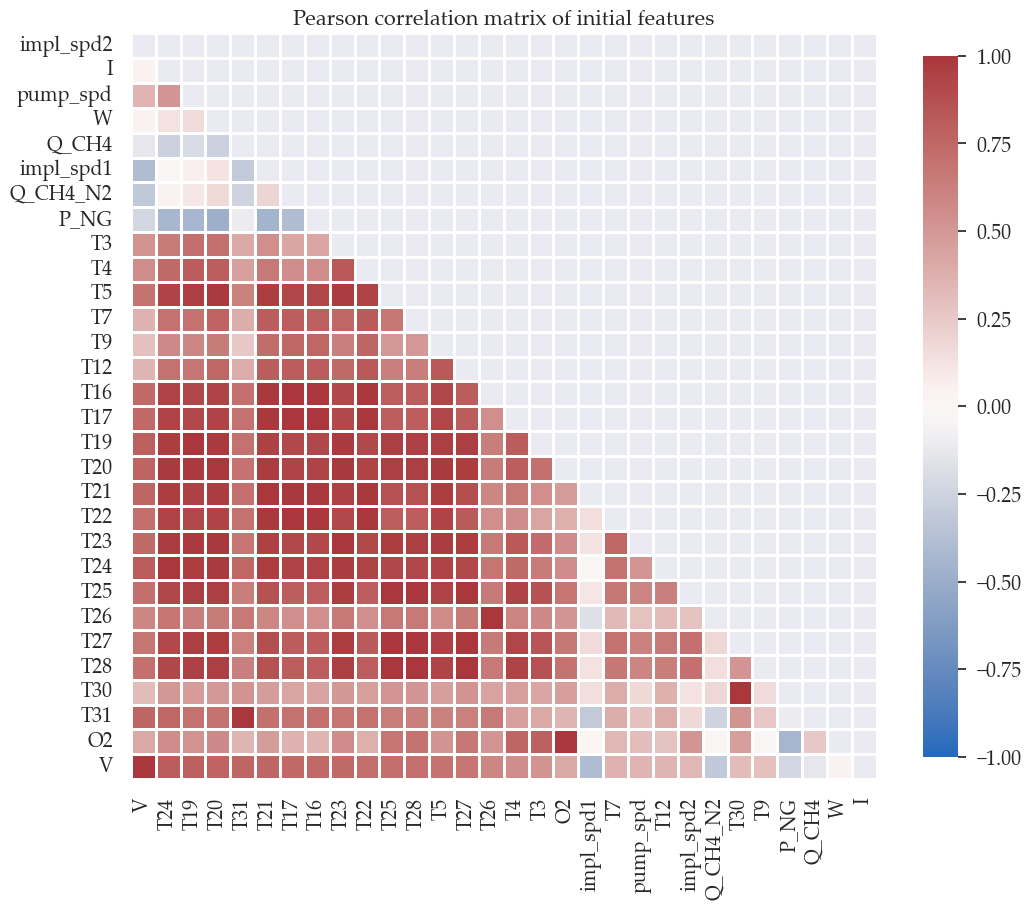

In [112]:
df_corr = df.corr('pearson')

# Let's sort column V by correlation strength (absolute value)
df_corr.sort_values(by='V', axis='columns', ascending=False, inplace=True, key=lambda col: abs(col))

#sns.set(font_scale=1.3)
#plt.rcParams['font.family'] = 'Palatino Linotype'

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, 
            #annot=True, 
            mask=mask, 
            cmap=sns.color_palette("vlag", as_cmap=True), 
            fmt=".3f", 
            vmax=1.0, 
            vmin=-1.0, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .8}).set(title='Pearson correlation matrix of initial features')

plt.tight_layout()
plt.savefig('pictures/full_corr_matrix.png', dpi = 300, transparent = True)
#df_corr.style.background_gradient(cmap=sns.color_palette("vlag", as_cmap=True), vmin = -1, vmax=1)  # output table-factor

## Data preprocessing

In [5]:
X = df.drop(columns='V').copy()  # input feature
y = df.V.copy()  # target feature (Voltage [V])

# Standardization of input feature general set 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=random_state)

## Feature important

### XGBoost features importance (MDI)

In [6]:
n = 11  # base component count

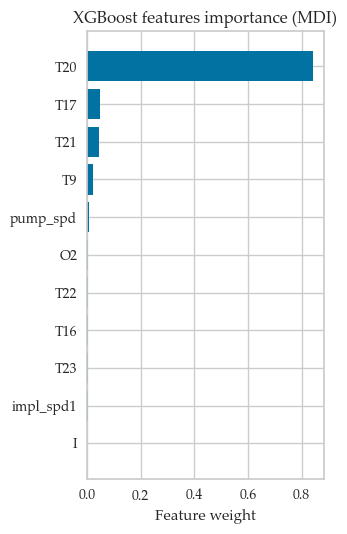

In [7]:
selector = xgb.XGBRegressor(random_state=random_state)
selector.fit(X_std, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features
MDI_columns = feature_importances.sort_values(by='importance', ascending=False).index

plt.figure(figsize=(3.5, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.title('XGBoost features importance (MDI)')
plt.tight_layout()
plt.savefig('pictures/standard_feature_important.png', dpi = 300, transparent = True)
plt.show()

### Permutation Importance (PI)

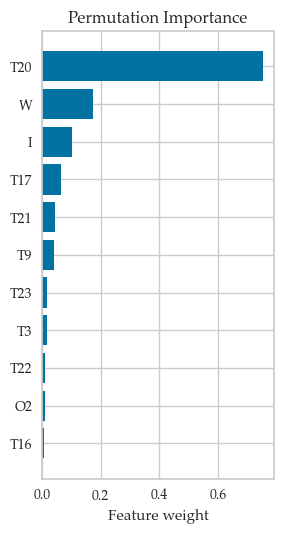

In [8]:
feature_importances = pd.DataFrame(
    {'importance' : permutation_importance(selector, X_std, y, n_repeats=5, 
                                           random_state=random_state, n_jobs=-1).importances_mean},
    index=X_std.columns).sort_values(by='importance', ascending=True)

feature_importances = feature_importances.iloc[-n:, :]  # get n-strongest features
PI_columns = feature_importances.sort_values(by='importance', ascending=False).index

plt.figure(figsize=(3, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.title('Permutation Importance')
plt.tight_layout()
plt.savefig('pictures/Permutation_Importance.png', dpi = 300, transparent = True)
plt.show()

### SHapley Additive exPlanations (SHAP)

In [9]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
    return feature_importance.set_index('features')

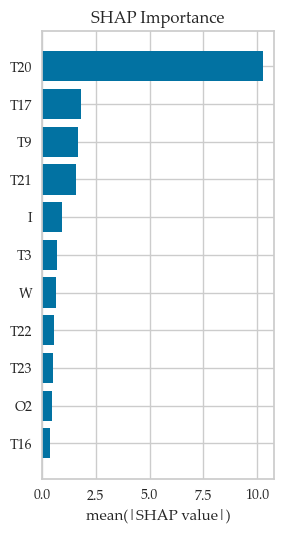

In [10]:
feature_importances = global_shap_importance(selector, X_std).iloc[:n, :]  # get n-strongest feature
SHAP_columns = feature_importances.index

feature_importances.sort_values(by=['importance'], ascending=True, inplace=True)
plt.figure(figsize=(3, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('mean(|SHAP value|)')
plt.title('SHAP Importance')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance2.png', dpi = 300, transparent = True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

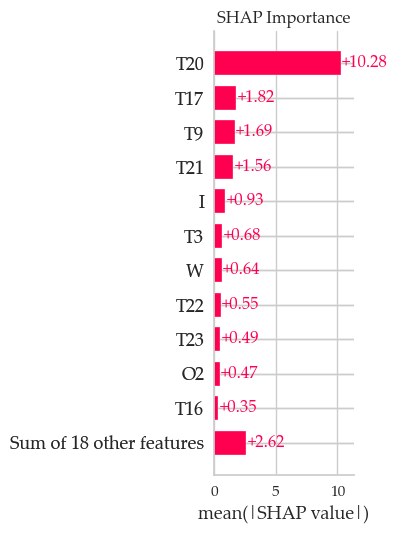

In [11]:
explainer = shap.Explainer(selector)
shap_importances = explainer(X_std)

shap.plots.bar(shap_importances, max_display=n+1, show=False)

plt.gcf().set_size_inches(4, n/2)
plt.title('SHAP Importance')
plt.tight_layout()
plt.savefig('pictures/SHAP_Importance.png', dpi = 300, transparent = True)
plt.show

###	Principal component analysis (PCA)

In [12]:
# Features PCA decomposition
n = 5  # number strongest features
pca = PCA(n_components=n)
pca.fit(X_std)
X_dec = pca.fit_transform(X_std)
X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

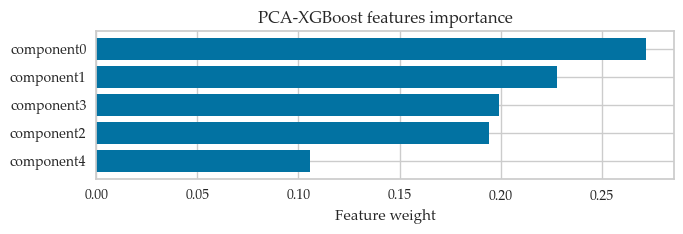

,importance
component4,0.105821
component2,0.194480
component3,0.199415
component1,0.228129
component0,0.272155


In [13]:
selector = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=random_state)
selector.fit(X_dec, y)

feature_importances = pd.DataFrame({'importance' : selector.feature_importances_}, 
                                   index=X_dec.columns).sort_values(by='importance', ascending=True)

plt.figure(figsize=(7, n/2))
plt.barh(range(len(feature_importances.index)), feature_importances.importance, align='center')
plt.yticks(range(len(feature_importances.index)), feature_importances.index)
plt.xlabel('Feature weight')
plt.title('PCA-XGBoost features importance')
plt.tight_layout()
plt.savefig('pictures/PCA-Decomposed_feature_important.png', dpi = 300, transparent = True)
plt.show()

feature_importances

# Fit models

In [14]:
# dataFrame with search result
search_result = pd.DataFrame(columns=['R2_score', 'MSE', 'MAE', 'MAPE', 'seconds'])

## XGBoost

In [15]:
# XGBoost GridSearchCV option

n_splits=5

param_grid={'max_depth': range(2, 6),
            'learning_rate': [0.01, 0.1, 0.2],
            'gamma': [0, 0.1, 1, 10],
            #'min_child_weight': [0, 0.1, 1, 10]
           }

### default (full set)

In [16]:
%%time

start_time = time.time()
XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                        param_grid=param_grid, 
                        verbose=1,
                        #cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        cv=n_splits
                        )

XGB_grid.fit(X_train, y_train)
XGB_best = XGB_grid.best_estimator_
y_pred = XGB_best.predict(X_test)

elapsed_time = time.time() - start_time

print("Best XGBRegressor-params:", XGB_grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGBRegressor-params: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 5min 47s
Wall time: 45.4 s


In [17]:
search_result.loc['XGB default'] = (r2_score(y_pred, y_test),
                                    MSE(y_pred, y_test),
                                    MAE(y_pred, y_test),
                                    MAPE(y_pred, y_test),
                                    elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default XGBoost',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default XGBoost
r2_score: 0.9971
MSE: 0.9646
MAE: 0.3056
MAPE: 2.83%


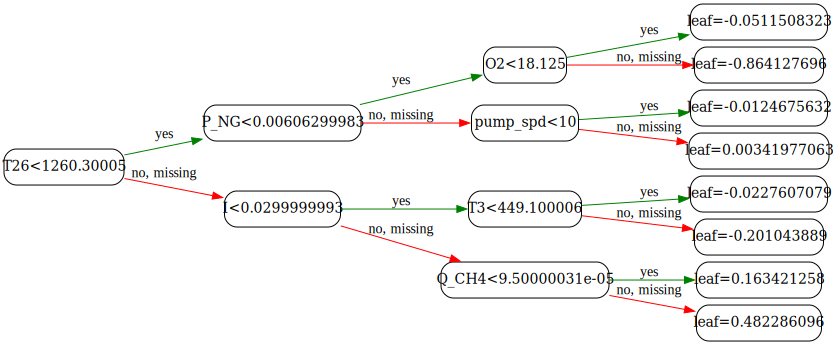

In [60]:
# Drawing the decision tree from the max_depth=3 XGboost model
model = xgb.XGBRegressor(random_state=random_state, max_depth=3)
model.fit(X, y)

graph_attr = {
    'fontsize': '16pt',
    'ranksep': '0.01',
    'splines': 'line',
    'fontname': 'Palatino Linotype',
    'nodesep' : '0.1'
}

graph = xgb.to_graphviz(model, num_trees=92, 
                        rankdir='LR',
                        **graph_attr,
                        no_color='#008000',
                        yes_color='red',
                        condition_node_params={'shape': 'box', 
                                               'style': 'rounded', 
                                               'fillcolor': 'none', 
                                               'fontname': 'Palatino Linotype',
                                               'fontsize': '14pt'
                                              },
                        leaf_node_params={'shape': 'box', 
                                          'style': 'rounded', 
                                          'fillcolor': 'none',
                                          'penwidth': '1pt',
                                          'fontname': 'Palatino Linotype',
                                          'fontsize': '14pt'},
                       )

graph.render('pictures/xgboost_tree', format='png', view=True, )
graph

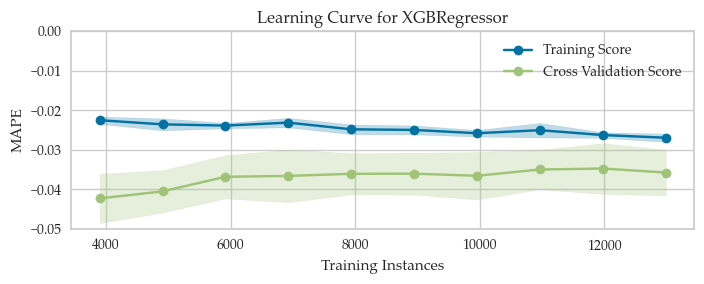

In [19]:
# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.3, 1.0, 10)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(XGB_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 300))

visualizer.fit(X_std,y)

plt.ylim(-0.05, 0)
plt.title('Learning Curve for XGBRegressor')
plt.xlabel('Training Instances')
plt.ylabel('MAPE')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_XGBR.png', dpi = 300, transparent = True)
plt.show()

### PCA

In [20]:
%%time

start_time = time.time()
df_PCA_XGB_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train2, X_dec_test2, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                            param_grid=param_grid, 
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                            #cv=n_splits
                            )

    XGB_grid.fit(X_dec_train2, y_train)
    print(f"Best XGBRegressor-params for {n} components", XGB_grid.best_params_)
    
    XGB_best = XGB_grid.best_estimator_
    y_pred = XGB_best.predict(X_dec_test2)
    
    df_PCA_XGB_search.loc[n] = (r2_score(y_pred, y_test),
                                MSE(y_pred, y_test), 
                                MAE(y_pred, y_test),
                                MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

components progress:   0%|          | 0/12 [00:00<?, ?it/s]

Best XGBRegressor-params for 5 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 7 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 9 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 11 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 13 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 15 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 17 components {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 19 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 21 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 23 components {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 25 components {'gamm

In [21]:
n = df_PCA_XGB_search.MAPE.idxmin()  # get optimal components number
search_result.loc[f'XGB+PCA({n})'] = (df_PCA_XGB_search.loc[n].r2_score,
                                      df_PCA_XGB_search.loc[n].MSE,
                                      df_PCA_XGB_search.loc[n].MAE,
                                      df_PCA_XGB_search.loc[n].MAPE,
                                      elapsed_time/(len(ParameterGrid(param_grid))*
                                                    n_splits*(len(range(5, X_train.shape[1], 2)))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_XGB_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_XGB_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_XGB_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_XGB_search.loc[n].MAPE:.2%}', sep='\n')

PCA 7 components
r2_score: 0.9949
MSE: 1.67
MAE: 0.4285
MAPE: 3.63%


In [22]:
df_PCA_XGB_search

,r2_score,MSE,MAE,MAPE
5,0.994693,1.742228,0.450851,0.091266
7,0.994917,1.669814,0.428545,0.036285
9,0.994928,1.668983,0.425456,0.037293
11,0.994672,1.752296,0.423407,0.049090
13,0.995216,1.573544,0.406373,0.061385
15,0.995232,1.567177,0.395816,0.046077
17,0.995440,1.496815,0.395318,0.045223
19,0.995446,1.496277,0.383609,0.039227
21,0.995470,1.487777,0.373619,0.039155
23,0.995678,1.423647,0.380410,0.039349


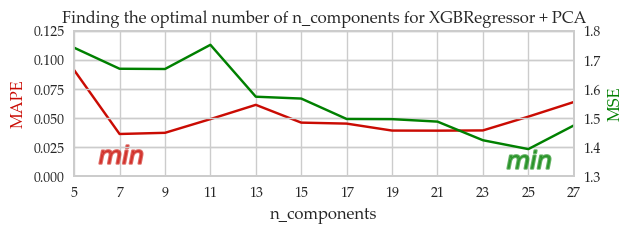

In [66]:
# plot search of the optimal parameter n_components of PCA
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_PCA_XGB_search.index, df_PCA_XGB_search.MAPE, color='r', label='MAPE')
mse.plot(df_PCA_XGB_search.index, df_PCA_XGB_search.MSE, color='green', label='MSE')

mape.set_xlabel('n_components', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, X_train.shape[1], step=2))
mape.set_yticks(ticks=np.arange(0.0, 0.126, step=0.025))
mape.set_xlim(left=5, right=27)
mape.set_ylim(0.0, 0.125)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_ylim(1.3, 1.8)
mse.set_yticks(ticks=np.arange(1.3, 1.81, step=0.1))
#mse.legend()

mape.scatter(df_PCA_XGB_search.MAPE.idxmin(), 
             df_PCA_XGB_search.MAPE.min()-0.017,
             linewidth=1.5,
             marker='$min$',
             color='r',
             alpha=0.6,
             s=1000)

mse.scatter(df_PCA_XGB_search.MSE.idxmin(), 
            df_PCA_XGB_search.MSE.min()-0.035,
            linewidth=1.5,
            marker='$min$',
            color='green',
            alpha=0.6,
            s=1000)

plt.title('Finding the optimal number of n_components for XGBRegressor + PCA', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/PCA_XGB_search.png', dpi = 300, transparent = True)
plt.show()

### SHAP

In [24]:
%%time

start_time = time.time()
df_SHAP_XGB_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, 12, desc=f"features progress"):

    X_train3 = X_train[SHAP_columns[:n]]
    X_test3 = X_test[SHAP_columns[:n]]

    XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                            param_grid=param_grid,
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state))

    XGB_grid.fit(X_train3, y_train)
    print(f"Best XGBRegressor-params for {n} features", XGB_grid.best_params_)
    
    XGB_best = XGB_grid.best_estimator_
    y_pred = XGB_best.predict(X_test3)
    
    df_SHAP_XGB_search.loc[n] = (r2_score(y_pred, y_test),
                                 MSE(y_pred, y_test), 
                                 MAE(y_pred, y_test),
                                 MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

features progress:   0%|          | 0/7 [00:00<?, ?it/s]

Best XGBRegressor-params for 5 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 6 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 7 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 8 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 9 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 10 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 11 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 20min 7s
Wall time: 2min 37s


In [25]:
n = df_SHAP_XGB_search.MAPE.idxmin()
search_result.loc[f'XGB+SHAP({n})'] = (df_SHAP_XGB_search.loc[n].r2_score,
                                       df_SHAP_XGB_search.loc[n].MSE,
                                       df_SHAP_XGB_search.loc[n].MAE,
                                       df_SHAP_XGB_search.loc[n].MAPE,
                                       elapsed_time/(len(ParameterGrid(param_grid))*
                                                     n_splits*len(range(5, 12))))
print(f'SHAP {n} features',
      f'r2_score: {df_SHAP_XGB_search.loc[n].r2_score:.4}',
      f'MSE: {df_SHAP_XGB_search.loc[n].MSE:.4}',
      f'MAE: {df_SHAP_XGB_search.loc[n].MAE:.4}',
      f'MAPE: {df_SHAP_XGB_search.loc[n].MAPE:.2%}', sep='\n')

SHAP 11 features
r2_score: 0.9965
MSE: 1.16
MAE: 0.3604
MAPE: 3.38%


In [26]:
df_SHAP_XGB_search

,r2_score,MSE,MAE,MAPE
5,0.994597,1.771105,0.536177,0.045775
6,0.995477,1.485095,0.464929,0.042714
7,0.996631,1.106874,0.416731,0.038788
8,0.996778,1.060513,0.397582,0.040814
9,0.996836,1.042103,0.361664,0.034995
10,0.996664,1.096961,0.354363,0.034918
11,0.996474,1.160200,0.360381,0.033798


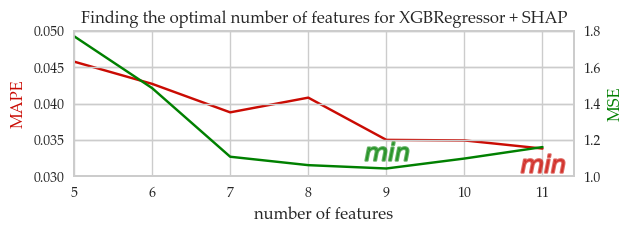

In [80]:
# plot search of the optimal number of features of SHAP
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_SHAP_XGB_search.index, df_SHAP_XGB_search.MAPE, color='r', label='MAPE')
mse.plot(df_SHAP_XGB_search.index, df_SHAP_XGB_search.MSE, color='green', label='MSE')

mape.set_xlabel('number of features', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, 12, step=1))
mape.set_yticks(ticks=np.arange(0.03, 0.05, step=0.005))
mape.set_xlim(left=5, right=11.4)
mape.set_ylim(0.03, 0.05)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_yticks(ticks=np.arange(1.0, 1.81, step=0.2))
mse.set_ylim(1.0, 1.8)
#mse.legend()

mape.scatter(df_SHAP_XGB_search.MAPE.idxmin(), 
             df_SHAP_XGB_search.MAPE.min()-0.002,
             linewidth=1.5,
             marker='$min$',
             color='r',
             alpha=0.6,
             s=1000)

mse.scatter(df_SHAP_XGB_search.MSE.idxmin(), 
            df_SHAP_XGB_search.MSE.min()+0.095,
            linewidth=1.5,
            marker='$min$',
            color='green',
            alpha=0.6,
            s=1000)

plt.title('Finding the optimal number of features for XGBRegressor + SHAP', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/SHAP_XGB_search.png', dpi = 300, transparent = True)
plt.show()

### PI

In [28]:
%%time

start_time = time.time()
df_PI_XGB_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, 12, desc=f"features progress"):

    X_train4 = X_train[PI_columns[:n]]
    X_test4 = X_test[PI_columns[:n]]

    XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                            param_grid=param_grid,
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state))

    XGB_grid.fit(X_train4, y_train)
    print(f"Best XGBRegressor-params for {n} features", XGB_grid.best_params_)
    
    XGB_best = XGB_grid.best_estimator_
    y_pred = XGB_best.predict(X_test4)
    
    df_PI_XGB_search.loc[n] = (r2_score(y_pred, y_test),
                               MSE(y_pred, y_test), 
                               MAE(y_pred, y_test),
                               MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

features progress:   0%|          | 0/7 [00:00<?, ?it/s]

Best XGBRegressor-params for 5 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 6 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 7 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 8 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 9 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 10 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 11 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 20min 5s
Wall time: 2min 36s


In [29]:
n = df_PI_XGB_search.MAPE.idxmin()
search_result.loc[f'XGB+PI({n})'] = (df_PI_XGB_search.loc[n].r2_score,
                                     df_PI_XGB_search.loc[n].MSE,
                                     df_PI_XGB_search.loc[n].MAE,
                                     df_PI_XGB_search.loc[n].MAPE,
                                     elapsed_time/(len(ParameterGrid(param_grid))*
                                                   n_splits*len(range(5, 12))))
print(f'PI {n} features',
      f'r2_score: {df_PI_XGB_search.loc[n].r2_score:.4}',
      f'MSE: {df_PI_XGB_search.loc[n].MSE:.4}',
      f'MAE: {df_PI_XGB_search.loc[n].MAE:.4}',
      f'MAPE: {df_PI_XGB_search.loc[n].MAPE:.2%}', sep='\n')

PI 11 features
r2_score: 0.9965
MSE: 1.159
MAE: 0.3594
MAPE: 3.38%


In [30]:
df_PI_XGB_search

,r2_score,MSE,MAE,MAPE
5,0.993032,2.278482,0.629654,0.069141
6,0.995886,1.349899,0.486545,0.046336
7,0.996499,1.149986,0.399786,0.033870
8,0.996997,0.988407,0.366581,0.036428
9,0.996825,1.045861,0.362134,0.035006
10,0.996678,1.092140,0.353430,0.034993
11,0.996479,1.158704,0.359382,0.033797


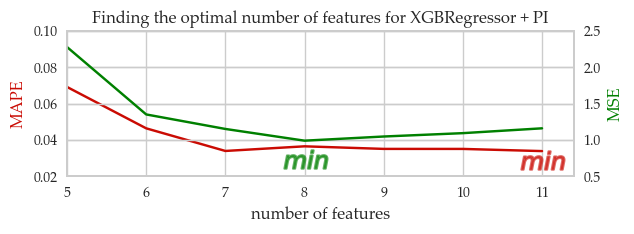

In [87]:
# plot search of the optimal number of features of PI
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_PI_XGB_search.index, df_PI_XGB_search.MAPE, color='r', label='MAPE')
mse.plot(df_PI_XGB_search.index, df_PI_XGB_search.MSE, color='green', label='MSE')

mape.set_xlabel('number of features', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, 12, step=1))
mape.set_yticks(ticks=np.arange(0.02, 0.101, step=0.02))
mape.set_xlim(left=5, right=11.4)
mape.set_ylim(0.02, 0.1)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_yticks(ticks=np.arange(0.5, 2.51, step=0.5))
mse.set_ylim(0.5, 2.5)
#mse.legend()

mape.scatter(df_PI_XGB_search.MAPE.idxmin(), 
             df_PI_XGB_search.MAPE.min()-0.005,
             linewidth=1.5,
             marker='$min$',
             color='r',
             alpha=0.6,
             s=1000)

mse.scatter(df_PI_XGB_search.MSE.idxmin(), 
            df_PI_XGB_search.MSE.min()-0.25,
            linewidth=1.5,
            marker='$min$',
            color='green',
            alpha=0.6,
            s=1000)

plt.title('Finding the optimal number of features for XGBRegressor + PI', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/PI_XGB_search.png', dpi = 300, transparent = True)
plt.show()

### MDI

In [32]:
%%time

start_time = time.time()
df_MDI_XGB_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, 12, desc=f"features progress"):

    X_train5 = X_train[MDI_columns[:n]]
    X_test5 = X_test[MDI_columns[:n]]

    XGB_grid = GridSearchCV(estimator=xgb.XGBRegressor(random_state=random_state),
                            param_grid=param_grid,
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state))

    XGB_grid.fit(X_train5, y_train)
    print(f"Best XGBRegressor-params for {n} features", XGB_grid.best_params_)
    
    XGB_best = XGB_grid.best_estimator_
    y_pred = XGB_best.predict(X_test5)
    
    df_MDI_XGB_search.loc[n] = (r2_score(y_pred, y_test),
                                MSE(y_pred, y_test), 
                                MAE(y_pred, y_test),
                                MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

features progress:   0%|          | 0/7 [00:00<?, ?it/s]

Best XGBRegressor-params for 5 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 6 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 7 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 8 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 9 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 10 features {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5}
Best XGBRegressor-params for 11 features {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 19min 48s
Wall time: 2min 33s


In [33]:
n = df_MDI_XGB_search.MAPE.idxmin()
search_result.loc[f'XGB+MDI({n})'] = (df_MDI_XGB_search.loc[n].r2_score,
                                      df_MDI_XGB_search.loc[n].MSE,
                                      df_MDI_XGB_search.loc[n].MAE,
                                      df_MDI_XGB_search.loc[n].MAPE,
                                      elapsed_time/(len(ParameterGrid(param_grid))*
                                                    n_splits*len(range(5, 12))))
print(f'MDI {n} features',
      f'r2_score: {df_MDI_XGB_search.loc[n].r2_score:.4}',
      f'MSE: {df_MDI_XGB_search.loc[n].MSE:.4}',
      f'MAE: {df_MDI_XGB_search.loc[n].MAE:.4}',
      f'MAPE: {df_MDI_XGB_search.loc[n].MAPE:.2%}', sep='\n')

MDI 11 features
r2_score: 0.9955
MSE: 1.462
MAE: 0.4064
MAPE: 3.61%


In [34]:
df_MDI_XGB_search

,r2_score,MSE,MAE,MAPE
5,0.993340,2.179575,0.589385,0.044305
6,0.993852,2.015451,0.518625,0.041076
7,0.994268,1.880789,0.487893,0.037254
8,0.994344,1.854325,0.490741,0.037304
9,0.994667,1.746839,0.474723,0.036274
10,0.994671,1.746221,0.466304,0.036078
11,0.995546,1.462319,0.406406,0.036057


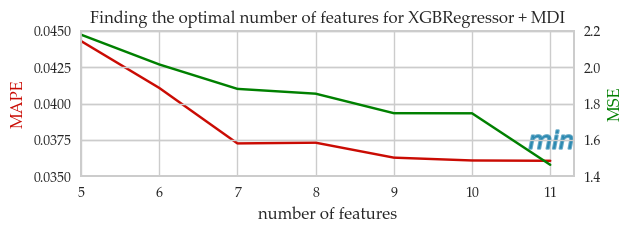

In [93]:
# plot search of the optimal number of features of MDI
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_MDI_XGB_search.index, df_MDI_XGB_search.MAPE, color='r', label='MAPE')
mse.plot(df_MDI_XGB_search.index, df_MDI_XGB_search.MSE, color='green', label='MSE')

mape.set_xlabel('number of features', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, 12, step=1))
mape.set_yticks(ticks=np.arange(0.035, 0.046, step=0.0025))
mape.set_xlim(left=5, right=11.3)
mape.set_ylim(0.035, 0.045)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_yticks(ticks=np.arange(1.2, 2.21, step=0.2))
mse.set_ylim(1.4, 2.2)
#mse.legend()

mape.scatter(df_MDI_XGB_search.MAPE.idxmin(), 
             df_MDI_XGB_search.MAPE.min()+0.0015,
             linewidth=1.5,
             marker='$min$',
             #color='r',
             alpha=0.6,
             s=1000)

'''mse.scatter(df_MDI_XGB_search.MSE.idxmin(), 
            df_MDI_XGB_search.MSE.min()-0.1,
            linewidth=1.5,
            marker='$min$',
            color='green',
            alpha=0.6,
            s=1000)'''

plt.title('Finding the optimal number of features for XGBRegressor + MDI', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/MDI_XGB_search.png', dpi = 300, transparent = True)
plt.show()

## Random forest

In [36]:
# XGBRF GridSearchCV option
n_splits=5

param_grid={'max_depth': [5, 10, 15]}

### default (full set)

In [37]:
%%time

start_time = time.time()
XGBRF_grid = GridSearchCV(estimator=xgb.XGBRFRegressor(random_state=random_state, n_estimators=100),
                        param_grid=param_grid, 
                        verbose=1,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                        #cv=n_splits,
                        )

XGBRF_grid.fit(X_train, y_train)
XGBRF_best = XGBRF_grid.best_estimator_
y_pred = XGBRF_best.predict(X_test)

elapsed_time = time.time() - start_time

print("Best XGBRFRegressor-params:", XGBRF_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best XGBRFRegressor-params: {'max_depth': 15}
CPU times: total: 7min 3s
Wall time: 55.4 s


In [38]:
search_result.loc['XGBRF default'] = (r2_score(y_pred, y_test),
                                      MSE(y_pred, y_test),
                                      MAE(y_pred, y_test),
                                      MAPE(y_pred, y_test),
                                      elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default XGBRF',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default XGBRF
r2_score: 0.997
MSE: 0.9835
MAE: 0.2606
MAPE: 1.10%


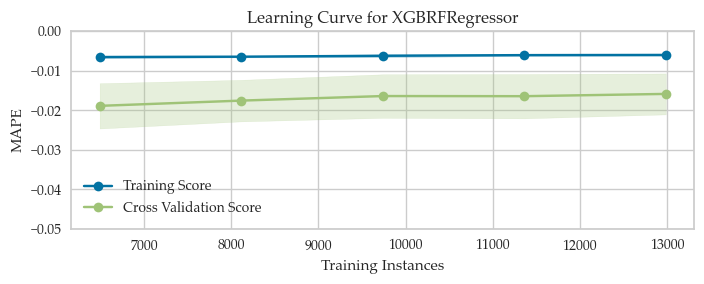

CPU times: total: 21min
Wall time: 2min 44s


In [39]:
%%time

# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.5, 1.0, 5)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(XGBRF_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 300))

visualizer.fit(X_std,y)

plt.ylim(-0.05, 0)
plt.title('Learning Curve for XGBRFRegressor')
plt.xlabel('Training Instances')
plt.ylabel('MAPE')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_XGBRFR.png', dpi = 300, transparent = True)
plt.show()

### PCA

In [40]:
%%time

start_time = time.time()
df_PCA_XGBRF_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train2, X_dec_test2, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    XGBRF_grid = GridSearchCV(estimator=xgb.XGBRFRegressor(random_state=random_state, n_estimators=100),
                              param_grid=param_grid, 
                              verbose=0,
                              cv=ShuffleSplit(n_splits=n_splits, random_state=random_state),
                              #cv=n_splits,
                              )

    XGBRF_grid.fit(X_dec_train2, y_train)
    print(f"Best XGBRFRegressor-params for {n} components", XGBRF_grid.best_params_)
    
    XGBRF_best = XGBRF_grid.best_estimator_
    y_pred = XGBRF_best.predict(X_dec_test2)
    
    df_PCA_XGBRF_search.loc[n] = (r2_score(y_pred, y_test),
                                  MSE(y_pred, y_test), 
                                  MAE(y_pred, y_test),
                                  MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

components progress:   0%|          | 0/12 [00:00<?, ?it/s]

Best XGBRFRegressor-params for 5 components {'max_depth': 15}
Best XGBRFRegressor-params for 7 components {'max_depth': 15}
Best XGBRFRegressor-params for 9 components {'max_depth': 15}
Best XGBRFRegressor-params for 11 components {'max_depth': 15}
Best XGBRFRegressor-params for 13 components {'max_depth': 15}
Best XGBRFRegressor-params for 15 components {'max_depth': 15}
Best XGBRFRegressor-params for 17 components {'max_depth': 15}
Best XGBRFRegressor-params for 19 components {'max_depth': 15}
Best XGBRFRegressor-params for 21 components {'max_depth': 15}
Best XGBRFRegressor-params for 23 components {'max_depth': 15}
Best XGBRFRegressor-params for 25 components {'max_depth': 15}
Best XGBRFRegressor-params for 27 components {'max_depth': 15}
CPU times: total: 59min 5s
Wall time: 7min 41s


In [41]:
n = df_PCA_XGBRF_search.MAPE.idxmin()  # get optimal count component
search_result.loc[f'XGBRF+PCA({n})'] = (df_PCA_XGBRF_search.loc[n].r2_score,
                                        df_PCA_XGBRF_search.loc[n].MSE,
                                        df_PCA_XGBRF_search.loc[n].MAE,
                                        df_PCA_XGBRF_search.loc[n].MAPE,
                                        elapsed_time/(len(ParameterGrid(param_grid))*
                                                      n_splits*len(range(5, X_train.shape[1], 2))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_XGBRF_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_XGBRF_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_XGBRF_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_XGBRF_search.loc[n].MAPE:.2%}', sep='\n')

PCA 21 components
r2_score: 0.9959
MSE: 1.338
MAE: 0.3151
MAPE: 1.45%


In [42]:
df_PCA_XGBRF_search

,r2_score,MSE,MAE,MAPE
5,0.995342,1.531694,0.322201,0.017195
7,0.995434,1.499059,0.341747,0.017229
9,0.995479,1.484873,0.346404,0.016280
11,0.995628,1.435384,0.340220,0.016087
13,0.995495,1.479038,0.347031,0.016323
15,0.995861,1.358834,0.332666,0.016245
17,0.995811,1.375042,0.329357,0.015472
19,0.995834,1.366943,0.333266,0.015519
21,0.995926,1.338340,0.315052,0.014514
23,0.995995,1.315650,0.320910,0.015111


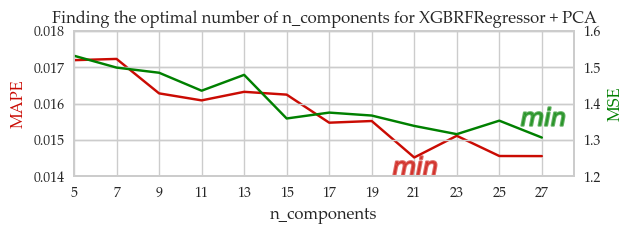

In [100]:
# plot search of the optimal parameter n_components of PCA
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_PCA_XGBRF_search.index, df_PCA_XGBRF_search.MAPE, color='r', label='MAPE')
mse.plot(df_PCA_XGBRF_search.index, df_PCA_XGBRF_search.MSE, color='green', label='MSE')

mape.set_xlabel('n_components', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, X_train.shape[1], step=2))
mape.set_yticks(ticks=np.arange(0.014, 0.0181, step=0.001))
mape.set_xlim(left=5, right=28.5)
mape.set_ylim(0.014, 0.018)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_ylim(1.2, 1.6)
mse.set_yticks(ticks=np.arange(1.2, 1.61, step=0.1))
#mse.legend()

mape.scatter(df_PCA_XGBRF_search.MAPE.idxmin(), 
             df_PCA_XGBRF_search.MAPE.min()-0.0002,
             linewidth=1.5,
             marker='$min$',
             color='r',
             alpha=0.6,
             s=1000)

mse.scatter(df_PCA_XGBRF_search.MSE.idxmin(), 
            df_PCA_XGBRF_search.MSE.min()+0.06,
            linewidth=1.5,
            marker='$min$',
            color='green',
            alpha=0.6,
            s=1000)

plt.title('Finding the optimal number of n_components for XGBRFRegressor + PCA', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/PCA_XGBRF_search.png', dpi = 300, transparent = True)
plt.show()

## Multi Layer Perceptron

In [44]:
n_splits=5

param_grid={'hidden_layer_sizes': [(i, i) for i in range(5, 50, 5)],
            'activation': ['relu', 'tanh', 'logistic'],
           }

This model is built according to the methodology described in the [article](https://www.mdpi.com/1996-1944/15/21/7760, "Performance Analysis of Anode-Supported Solid Oxide Fuel Cells: A Machine Learning Approach")

### default (full set)

In [45]:
%%time

start_time = time.time()
    
MLP_grid = GridSearchCV(estimator=MLPRegressor(random_state=random_state, 
                                               learning_rate='invscaling',
                                               learning_rate_init=0.055,
                                               solver='adam',
                                               max_iter=2000),
                        param_grid=param_grid,
                        scoring='neg_mean_absolute_percentage_error', 
                        verbose=0,
                        cv=ShuffleSplit(n_splits=n_splits, random_state=random_state)
                       )
    
MLP_grid.fit(X_train, y_train)    
MLP_best = MLP_grid.best_estimator_
y_pred = MLP_best.predict(X_test)

elapsed_time = time.time() - start_time
    
print(f"Best MLP-params:", MLP_grid.best_params_)

Best MLP-params: {'activation': 'logistic', 'hidden_layer_sizes': (30, 30)}
CPU times: total: 5min 51s
Wall time: 4min 40s


In [46]:
search_result.loc['MLP default'] = (r2_score(y_pred, y_test),
                                    MSE(y_pred, y_test),
                                    MAE(y_pred, y_test),
                                    MAPE(y_pred, y_test),
                                    elapsed_time/(len(ParameterGrid(param_grid))*n_splits))
print('default MLP',
      f'r2_score: {r2_score(y_pred, y_test):.4}',
      f'MSE: {MSE(y_pred, y_test):.4}',
      f'MAE: {MAE(y_pred, y_test):.4}',
      f'MAPE: {MAPE(y_pred, y_test):.2%}', sep='\n')

default MLP
r2_score: 0.9929
MSE: 2.296
MAE: 0.7989
MAPE: 8.73%


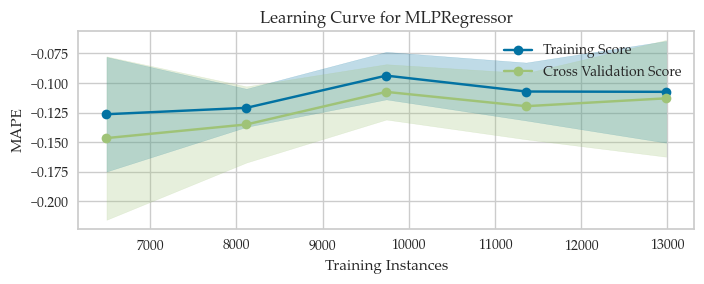

CPU times: total: 391 ms
Wall time: 10.3 s


In [101]:
%%time

# Plotting learning curve for XGBoost regressor
cv = ShuffleSplit(n_splits=5, random_state=random_state)
sizes = np.linspace(0.5, 1.0, 5)
plt.figure(figsize=(8,6))
visualizer = LearningCurve(MLP_best, 
                           cv=cv, 
                           scoring='neg_mean_absolute_percentage_error', 
                           train_sizes=sizes, n_jobs=-1, size=(720, 300))

visualizer.fit(X_std,y)

#plt.ylim(-0.09, -0.04)
plt.title('Learning Curve for MLPRegressor')
plt.xlabel('Training Instances')
plt.ylabel('MAPE')
plt.legend()
plt.tight_layout()
plt.savefig('pictures/Learning_Curve_for_MLP.png', dpi = 300, transparent = True)
plt.show()

### PCA

In [48]:
%%time

start_time = time.time()
df_PCA_MLP_search = pd.DataFrame(columns=['r2_score', 'MSE', 'MAE', 'MAPE'])

for n in trange(5, X_train.shape[1], 2, desc=f"components progress"):
    pca = PCA(n_components=n)
    pca.fit(X_std)
    X_dec = pca.fit_transform(X_std)
    X_dec = pd.DataFrame(X_dec, columns=[f'component{i}' for i in range(n)])

    X_dec_train, X_dec_test, y_train, y_test = train_test_split(X_dec, y, test_size=0.2, random_state=random_state)
    
    MLP_grid = GridSearchCV(estimator=MLPRegressor(random_state=random_state, 
                                                   learning_rate='invscaling',
                                                   learning_rate_init=0.055,
                                                   solver='adam',
                                                   max_iter=2000),
                            param_grid=param_grid,
                            scoring='neg_mean_absolute_percentage_error',
                            verbose=0,
                            cv=ShuffleSplit(n_splits=n_splits, random_state=random_state)
                            )
    
    MLP_grid.fit(X_dec_train, y_train)
    print(f"Best MLP-params for {n} components", MLP_grid.best_params_)
    
    MLP_best = MLP_grid.best_estimator_
    y_pred = MLP_best.predict(X_dec_test)
    
    df_PCA_MLP_search.loc[n] = (r2_score(y_pred, y_test),
                                MSE(y_pred, y_test), 
                                MAE(y_pred, y_test),
                                MAPE(y_pred, y_test))

elapsed_time = time.time() - start_time

components progress:   0%|          | 0/12 [00:00<?, ?it/s]

Best MLP-params for 5 components {'activation': 'logistic', 'hidden_layer_sizes': (40, 40)}
Best MLP-params for 7 components {'activation': 'logistic', 'hidden_layer_sizes': (40, 40)}
Best MLP-params for 9 components {'activation': 'logistic', 'hidden_layer_sizes': (45, 45)}
Best MLP-params for 11 components {'activation': 'tanh', 'hidden_layer_sizes': (35, 35)}
Best MLP-params for 13 components {'activation': 'tanh', 'hidden_layer_sizes': (20, 20)}
Best MLP-params for 15 components {'activation': 'tanh', 'hidden_layer_sizes': (45, 45)}
Best MLP-params for 17 components {'activation': 'tanh', 'hidden_layer_sizes': (35, 35)}
Best MLP-params for 19 components {'activation': 'logistic', 'hidden_layer_sizes': (15, 15)}
Best MLP-params for 21 components {'activation': 'logistic', 'hidden_layer_sizes': (20, 20)}
Best MLP-params for 23 components {'activation': 'logistic', 'hidden_layer_sizes': (15, 15)}
Best MLP-params for 25 components {'activation': 'logistic', 'hidden_layer_sizes': (45, 4

In [49]:
n = df_PCA_MLP_search.MAPE.idxmin()
search_result.loc[f'MLP+PCA({n})'] = (df_PCA_MLP_search.loc[n].r2_score,
                                        df_PCA_MLP_search.loc[n].MSE,
                                        df_PCA_MLP_search.loc[n].MAE,
                                        df_PCA_MLP_search.loc[n].MAPE,
                                        elapsed_time/(len(ParameterGrid(param_grid))*
                                                      n_splits*len(range(5, X_train.shape[1], 2))))
print(f'PCA {n} components',
      f'r2_score: {df_PCA_MLP_search.loc[n].r2_score:.4}',
      f'MSE: {df_PCA_MLP_search.loc[n].MSE:.4}',
      f'MAE: {df_PCA_MLP_search.loc[n].MAE:.4}',
      f'MAPE: {df_PCA_MLP_search.loc[n].MAPE:.2%}', sep='\n')

PCA 21 components
r2_score: 0.9963
MSE: 1.203
MAE: 0.3808
MAPE: 4.23%


In [50]:
df_PCA_MLP_search

,r2_score,MSE,MAE,MAPE
5,0.986241,4.461736,1.004226,0.118208
7,0.990872,2.988263,0.810363,0.059883
9,0.904839,28.298936,3.952964,0.162474
11,0.992672,2.419857,0.748954,0.098013
13,0.990261,3.227612,0.868060,0.097192
15,0.994567,1.800746,0.590830,0.080331
17,0.994776,1.719567,0.516244,0.073014
19,0.994810,1.703876,0.542976,0.066546
21,0.996342,1.203150,0.380753,0.042262
23,0.995149,1.591840,0.500557,0.064955


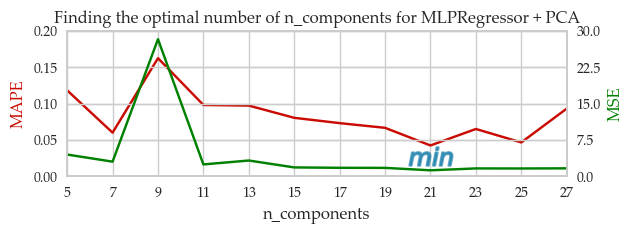

In [111]:
# plot search of the optimal parameter n_components of PCA
fig, mape = plt.subplots(figsize=(6.5, 2.5))
mse = mape.twinx()

mape.plot(df_PCA_MLP_search.index, df_PCA_MLP_search.MAPE, color='r', label='MAPE')
mse.plot(df_PCA_MLP_search.index, df_PCA_MLP_search.MSE, color='green', label='MSE')

mape.set_xlabel('n_components', fontsize = 12)
mape.set_ylabel('MAPE', fontsize = 12, color='r')
mape.set_xticks(ticks=np.arange(5, X_train.shape[1], step=2))
mape.set_yticks(ticks=np.arange(0.0, 0.21, step=0.05))
mape.set_xlim(left=5, right=27)
mape.set_ylim(0.0, 0.2)
#mape.legend()

mse.set_ylabel('MSE', fontsize = 12, color='green')
mse.set_ylim(0, 30)
mse.set_yticks(ticks=np.arange(0, 31, step=7.5))
#mse.legend()

'''mape.scatter(df_PCA_MLP_search.MAPE.idxmin(), 
             df_PCA_MLP_search.MAPE.min()+0.05,
             linewidth=1.5,
             marker='$min$',
             color='r',
             alpha=0.6,
             s=1000)'''

mse.scatter(df_PCA_MLP_search.MSE.idxmin(), 
            df_PCA_MLP_search.MSE.min()+3,
            linewidth=1.5,
            marker='$min$',
            #color='green',
            alpha=0.6,
            s=1000)

plt.title('Finding the optimal number of n_components for MLPRegressor + PCA', fontsize = 12)
plt.tight_layout()
plt.savefig('pictures/PCA_MLP_search.png', dpi = 300, transparent = True)
plt.show()

# Result

In [52]:
df_search_result = search_result.copy()

df_search_result = df_search_result.style.format({'R2_score': '{:.5f}', 
                                                  'MSE': '{:.4f}', 
                                                  'MAE': '{:.3f}',
                                                  'MAPE': '{:.2%}',
                                                  'seconds': '{:.6f}'
                                                 }).background_gradient(cmap=sns.color_palette("vlag", as_cmap=True))

#pd.set_option('display.float_format', lambda x: '%.6f' % x)
#search_result.to_excel('search_result.xlsx', index=True)

df_search_result

,R2_score,MSE,MAE,MAPE,seconds
XGB default,0.99707,0.9646,0.306,2.83%,0.189227
XGB+PCA(7),0.99492,1.6698,0.429,3.63%,0.151798
XGB+SHAP(11),0.99647,1.1602,0.360,3.38%,0.093884
XGB+PI(11),0.99648,1.1587,0.359,3.38%,0.093288
XGB+MDI(11),0.99555,1.4623,0.406,3.61%,0.091611
XGBRF default,0.99701,0.9835,0.261,1.10%,3.690712
XGBRF+PCA(21),0.99593,1.3383,0.315,1.45%,2.564883
MLP default,0.99295,2.2964,0.799,8.73%,2.077358
MLP+PCA(21),0.99634,1.2032,0.381,4.23%,2.109777


In [53]:
df_PCA_XGB_search.to_excel('article/backup2/PCA_XGB_search.xlsx')
df_SHAP_XGB_search.to_excel('article/backup2/SHAP_XGB_search.xlsx')
df_PI_XGB_search.to_excel('article/backup2/PI_XGB_search.xlsx')
df_MDI_XGB_search.to_excel('article/backup2/MDI_XGB_search.xlsx')
df_PCA_XGBRF_search.to_excel('article/backup2/PCA_XGBRF_search.xlsx')
df_PCA_MLP_search.to_excel('article/backup2/PCA_MLP_search.xlsx')
df_search_result.to_excel('article/backup2/search_result.xlsx')

#df_PCA_XGB_search = pd.read_excel('article/backup2/PCA_XGB_search.xlsx', index_col='Unnamed: 0')
#df_SHAP_XGB_search = pd.read_excel('article/backup2/SHAP_XGB_search.xlsx', index_col='Unnamed: 0')
#df_PI_XGB_search = pd.read_excel('article/backup2/PI_XGB_search.xlsx', index_col='Unnamed: 0')
#df_MDI_XGB_search = pd.read_excel('article/backup2/MDI_XGB_search.xlsx', index_col='Unnamed: 0')
#df_PCA_XGBRF_search = pd.read_excel('article/backup2/PCA_XGBRF_search.xlsx', index_col='Unnamed: 0')
#df_PCA_MLP_search = pd.read_excel('article/backup2/PCA_MLP_search.xlsx', index_col='Unnamed: 0')
#df_search_result= pd.read_excel('article/backup2/search_result.xlsx', index_col='Unnamed: 0')